In [1]:
import pandas as pd
import numpy as np
from scipy import sparse as sps
import nltk
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from lenskit.batch import MultiEval
from lenskit.crossfold import partition_users, SampleN, partition_rows
from lenskit import topn
from tf_idf import tf_idf
from lenskit import batch, topn, util

In [3]:
import lenskit
import lenskit.crossfold as xf
from  lenskit.crossfold import TTPair

In [4]:
saved = open("pickle/game_reviews.pickle","rb")
game_reviews = pickle.load(saved)
game_reviews.head()

,funny,helpful,item_id,last_edited,posted,recommend,review,user_id
0,,No ratings yet,1250,,"Posted November 5, 2011.",True,Simple yet with great replayability. In my opi...,76561197970982479
1,,No ratings yet,22200,,"Posted July 15, 2011.",True,It's unique and worth a playthrough.,76561197970982479
2,,No ratings yet,43110,,"Posted April 21, 2011.",True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479
3,,15 of 20 people (75%) found this review helpful,251610,,"Posted June 24, 2014.",True,I know what you think when you see this title ...,js41637
4,,0 of 1 people (0%) found this review helpful,227300,,"Posted September 8, 2013.",True,For a simple (it's actually not all that simpl...,js41637


In [5]:
game_reviews.isnull().any()

funny          False
helpful        False
item_id        False
last_edited    False
posted         False
recommend      False
review         False
user_id        False
dtype: bool

In [6]:
game_reviews.dropna(inplace=True)
game_reviews = game_reviews.applymap(str)
#game_reviews['review'] = game_reviews[game_reviews['review'].apply(lambda x: type(x)==str)]

In [7]:
game_reviews.shape

(58430, 8)

In [8]:
type(game_reviews['review'][674])

str

In [9]:
reviews = game_reviews[['item_id', 'user_id','review']]
reviews = reviews.rename(columns={'user_id': 'user', 'item_id': 'item'})
reviews.head()

,item,user,review
0,1250,76561197970982479,Simple yet with great replayability. In my opi...
1,22200,76561197970982479,It's unique and worth a playthrough.
2,43110,76561197970982479,Great atmosphere. The gunplay can be a bit chu...
3,251610,js41637,I know what you think when you see this title ...
4,227300,js41637,For a simple (it's actually not all that simpl...


### item count and remove user less than (n)

In [10]:
def groupby_count(df, group, count):
    game_count = pd.DataFrame()
    game_count['count'] = df.groupby(group)[count].count()
    return game_count

In [11]:
def locate_user(df, condition):
    user_n = df.loc[df['count'] < condition ]
    return user_n

In [12]:
game_count = groupby_count(reviews, 'user', 'item')
#user_5 = game_count.loc[game_count['count'] < 5 ]
user_5 = locate_user(game_count, 5)

In [13]:
user_less_5 = user_5.index
user_less_5

Index(['--000--', '--ace--', '--ionex--', '-Azsael-', '-Beave-', '-GM-Dragon',
       '-I_AM_EPIC-', '-Kenny', '-Mad-', '-PRoSlayeR-',
       ...
       'zucchin1', 'zudikas', 'zukuta', 'zumpo', 'zunbae', 'zvanik',
       'zwanzigdrei', 'zy0705', 'zynxgameth', 'zzoptimuszz'],
      dtype='object', name='user', length=22185)

In [14]:
game_count.sort_values(by = ['count']).head()

,count
user,
--000--,1
Dylbugs,1
Dyllz,1
Dynsomnia,1
Dyrrrrran,1


## remove less than 5 review provider users 

In [15]:
pruned_data_5 = reviews.set_index('user').drop(user_less_5)
pruned_data_5.reset_index(inplace = True)
pruned_data_5.head()
#pruned_data_5.isnull().any()

,user,item,review
0,evcentric,248820,A suitably punishing roguelike platformer. Wi...
1,evcentric,370360,"""Run for fun? What the hell kind of fun is that?"""
2,evcentric,237930,"Elegant integration of gameplay, story, world ..."
3,evcentric,263360,"Random drops and random quests, with stat poin..."
4,evcentric,107200,Fun balance of tactics and strategy. Potentia...


## check user item

In [16]:
pruned_data_5.loc[pruned_data_5['user'] == 'kenkaniff']

,user,item,review
18433,kenkaniff,42680,This is honestly the worst Call of Duty ever. ...
18434,kenkaniff,242050,Great game! Recommend it!
18435,kenkaniff,209160,Not that great of a game actually! The multipl...
18436,kenkaniff,8190,This is one of my favourite games! It is reall...
18437,kenkaniff,24240,"Love it, can't stop playing it!!"


In [17]:
pruned_data_5.iloc[133]

user      76561198088944293
item                 437701
review      were is my ♥♥♥♥
Name: 133, dtype: object

## Partition by user

In [18]:
pairs_user = list(partition_users(pruned_data_5, 5, xf.SampleN(3)))
truth = pd.concat((p.test for p in pairs_user))
truth.to_csv(r'results/steam/truth_user.csv')

## Evaluation

In [19]:
def algo_eval(path, algo, dataset):
    evaluation = batch.MultiEval(path=path, predict=False, recommend=True)
    evaluation.add_algorithms(algos=algo, paraller = True)
    evaluation.add_datasets(data=dataset)
    evaluation.run()

In [20]:
def ndcg(file_name, truth):
    recs = pd.read_parquet(file_name)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    ndcg = rla.compute(recs, truth)
    return ndcg

## fit & compare

In [21]:
from lenskit.algorithms import als, basic, item_knn, user_knn
from lenskit.metrics import topn as tnmetrics
from lenskit.algorithms.basic import Fallback
from lenskit.algorithms.als import BiasedMF, ImplicitMF
from lenskit.algorithms.implicit import BPR

In [22]:
algo_ii = item_knn.ItemItem(20, center=False, aggregate='sum')
#algo_uu = user_knn.UserUser(30, center=False, aggregate='sum')
algo_pop = basic.Popular()
algo_mf = ImplicitMF(40)
algo_bpr = BPR()
algo_tf_idf = tf_idf()

In [24]:
%%time
algo_eval('results/steam/user_part/all_algo', [algo_tf_idf,algo_ii, algo_pop,algo_mf,algo_bpr], pairs_user)

/home/amifaraj/anaconda3/lib/python3.7/site-packages/fastparquet/util.py:221: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  inferred_dtype = infer_dtype(column)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/fastparquet/util.py:221: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  inferred_dtype = infer_dtype(column)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_d

CPU times: user 12min 8s, sys: 29.3 s, total: 12min 37s
Wall time: 9min 7s


In [25]:
ndcg_algo_comp = ndcg('results/steam/user_part/all_algo/recommendations.parquet', truth)
ndcg_algo_comp.head()

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


ndcg
user         RunId          
-2SV-vuLB-Kg 16     0.181216
             17     0.157306
             18     0.819974
             19     0.116589
             20     0.110272

In [37]:
legend = pd.read_csv("results/steam/user_part/all_algo/runs.csv")
legend = legend.set_index('RunId').loc[:,'AlgoStr']
ndcg_algo = ndcg_algo_comp.join(legend, on='RunId')
ndcg_algo['AlgoStr'].replace('<tf_idf.tf_idf object at 0x7ffb92caf1d0>', 'TF-IDF', inplace = True)
ndcg_algo.head(10)

ndcg  \
user         RunId             
-2SV-vuLB-Kg 16     0.181216   
             17     0.157306   
             18     0.819974   
             19     0.116589   
             20     0.110272   
-SEVEN-      11     0.119577   
             12     0.277992   
             13     0.429866   
             14     0.273738   
             15     0.151851   

                                                              AlgoStr  
user         RunId                                                     
-2SV-vuLB-Kg 16                                                TF-IDF  
             17                        ItemItem(nnbrs=20, msize=None)  
             18                                               Popular  
             19            als.ImplicitMF(features=40, reg=0.1, w=40)  
             20     Implicit(<implicit.bpr.BayesianPersonalizedRan...  
-SEVEN-      11                                                TF-IDF  
             12                        ItemItem(nnbrs=20, msize=None)  
             13                                               Popular  
             14            als.ImplicitMF(features=40, reg=0.1, w=40)  
             15     Implicit(<implicit.bpr.BayesianPersonalizedRan...

## compare

In [39]:
ndcg_algo.reset_index(inplace = True)

In [43]:
ndcg_by_algo = pd.DataFrame(ndcg_algo.groupby(['AlgoStr']).ndcg.mean())
ndcg_by_algo.reset_index(inplace = True)

In [46]:
ndcg_by_algo

,AlgoStr,ndcg
0,Implicit(<implicit.bpr.BayesianPersonalizedRan...,0.137251
1,"ItemItem(nnbrs=20, msize=None)",0.197411
2,Popular,0.286053
3,TF-IDF,0.223258
4,"als.ImplicitMF(features=40, reg=0.1, w=40)",0.204802


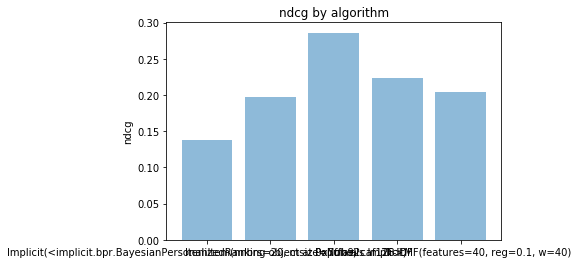

In [45]:
import numpy as np
import matplotlib.pyplot as plt

X = ndcg_by_algo['AlgoStr']
Y = ndcg_by_algo['ndcg']


plt.bar(X,Y, align='center', alpha=0.5)
plt.xlabel = ('Algorithm')
plt.ylabel('ndcg')
plt.title('ndcg by algorithm')

plt.show()

## No need for now

In [22]:
%%time
algo_eval('results/steam/user_part', tf_idf(), pairs_user)

/home/amifaraj/anaconda3/lib/python3.7/site-packages/fastparquet/util.py:221: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  inferred_dtype = infer_dtype(column)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/fastparquet/util.py:221: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  inferred_dtype = infer_dtype(column)


CPU times: user 8min 27s, sys: 27 s, total: 8min 54s
Wall time: 8min 43s


In [23]:
ndcg_tfidf = ndcg('results/steam/user_part/recommendations.parquet', truth)
ndcg_tfidf.head()

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,,ndcg
user,RunId,
-2SV-vuLB-Kg,1,0.102282
-SEVEN-,3,0.146327
-_PussyDestroyer_-,1,0.183387
00000000000000000001227,1,0.255079
01189958889189157253,2,0.293961


## ndcg

In [32]:
ndcg_tfidf_pop = ndcg('results/steam/time/recommendations.parquet', truth)
ndcg_tfidf_pop.head()

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


ndcg
user         RunId          
-2SV-vuLB-Kg 1      0.041484
             2      0.000000
             3      0.311048
             5      0.050007
-SEVEN-      2      0.054555

## compare

## testing

In [27]:
%%time
algo_eval('results/steam/user_part/compare', [algo_ii, algo_pop,algo_mf,algo_bpr], pairs_user)

/home/amifaraj/anaconda3/lib/python3.7/site-packages/fastparquet/util.py:221: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  inferred_dtype = infer_dtype(column)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/fastparquet/util.py:221: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  inferred_dtype = infer_dtype(column)
/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_d

CPU times: user 4min 21s, sys: 4.54 s, total: 4min 26s
Wall time: 1min 4s


In [29]:
ndcg_algo_comp = ndcg('results/steam/user_part/compare/recommendations.parquet', truth)
ndcg_algo_comp.head()

ndcg
user         RunId          
-2SV-vuLB-Kg 1      0.095272
             2      0.101951
             3      0.089192
             4      0.068937
-SEVEN-      9      0.177938

In [32]:
legend = pd.read_csv("results/steam/user_part/compare/runs.csv")
legend = legend.set_index('RunId').loc[:,'AlgoStr']
ndcg_algo = ndcg_algo_comp.join(legend, on='RunId')
ndcg_algo.head(10)

ndcg  \
user               RunId             
-2SV-vuLB-Kg       1      0.095272   
                   2      0.101951   
                   3      0.089192   
                   4      0.068937   
-SEVEN-            9      0.177938   
                   10     0.174992   
                   11     0.135223   
                   12     0.416910   
-_PussyDestroyer_- 1      0.128158   
                   2      0.475403   

                                                                    AlgoStr  
user               RunId                                                     
-2SV-vuLB-Kg       1                         ItemItem(nnbrs=20, msize=None)  
                   2                                                Popular  
                   3             als.ImplicitMF(features=40, reg=0.1, w=40)  
                   4      Implicit(<implicit.bpr.BayesianPersonalizedRan...  
-SEVEN-            9                         ItemItem(nnbrs=20, msize=None)  
                   10                                               Popular  
                   11            als.ImplicitMF(features=40, reg=0.1, w=40)  
                   12     Implicit(<implicit.bpr.BayesianPersonalizedRan...  
-_PussyDestroyer_- 1                         ItemItem(nnbrs=20, msize=None)  
                   2                                                Popular

## test

In [131]:
for i, tp in enumerate(xf.partition_users(pruned_data, 5, xf.SampleN(5))):
    tp.train.to_csv('steam/train_pruned-%d.csv' % (i,))
    tp.train.to_parquet('steam/train_pruned-%d.parquet' % (i,))
    tp.test.to_csv('steam/test_pruned-%d.csv' % (i,))
    tp.test.to_parquet('steam/test_pruned-%d.parquet' % (i,))

/home/amifaraj/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


In [6]:
test_data=[]
tt_tuples =[]
for i in range(0,5):
    train = pd.read_csv('steam/train_pruned-{}.csv'.format(i))
    train.drop(columns=['Unnamed: 0'],inplace = True)
    test = pd.read_csv('steam/test_pruned-{}.csv'.format(i))
    test.drop(columns=['Unnamed: 0'],inplace = True)
    test_data.append(test)
    tuple = (train, test)
    tt_tuples.append(tuple)

In [14]:
tt_tuples[1][0].isna().any().index.tolist()
#df.columns[df.isna().any()].tolist()

['user', 'item', 'review']

In [141]:
train.loc[train['user'] == 'evcentric']

,Unnamed: 0,user,item,review
0,0,evcentric,248820,A suitably punishing roguelike platformer. Wi...
1,1,evcentric,370360,"""Run for fun? What the hell kind of fun is that?"""
2,2,evcentric,237930,"Elegant integration of gameplay, story, world ..."


In [140]:
test.loc[test['user'] == 'evcentric']

,Unnamed: 0,user,item,review
2463,3,evcentric,263360,"Random drops and random quests, with stat poin..."
2464,5,evcentric,224500,"Fun world builder, with plenty of option of ho..."
2465,4,evcentric,107200,Fun balance of tactics and strategy. Potentia...


In [138]:
test = pd.read_csv('steam/test_pruned-0.csv')
test.head()

,Unnamed: 0,user,item,review
0,16086,-SEVEN-,274940,"Игра мне понравилась , классная атмосфера подв..."
1,16094,-SEVEN-,242050,"Классная игра , самая лучшая серия ассасин Кри..."
2,16087,-SEVEN-,406210,Довольно не плохо сняли нарезочки Virtus.pro с...
3,21171,-_PussyDestroyer_-,323500,so the dlc gives you a bunch of weps that are ...
4,21170,-_PussyDestroyer_-,12210,pretty ♥♥♥♥!


In [18]:
train = pd.read_csv('steam/train_pruned-1.csv')
train.head()

,Unnamed: 0,user,item,review
0,0,evcentric,248820,A suitably punishing roguelike platformer. Wi...
1,1,evcentric,370360,"""Run for fun? What the hell kind of fun is that?"""
2,2,evcentric,237930,"Elegant integration of gameplay, story, world ..."
3,3,evcentric,263360,"Random drops and random quests, with stat poin..."
4,4,evcentric,107200,Fun balance of tactics and strategy. Potentia...


In [23]:
#train['review'].isna().any()
train[train['review'].isnull()].index.tolist()

[7237, 8155, 8397, 9000, 12786, 14099, 14657, 18082]

In [25]:
train.iloc[7237]

Unnamed: 0                 8584
user          76561197971285616
item                     378041
review                      NaN
Name: 7237, dtype: object

In [8]:
eval = MultiEval('my-eval', recommend=10)
eval.add_datasets(tt_tuples, name='steam')
eval.add_algorithms(tf_idf(), name='tf_idf')
eval.run()

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [133]:
eval = MultiEval('my-eval', recommend=10)
eval.add_datasets(tt_tuples, name='steam')
eval.add_algorithms(tf_idf(), name='tf_idf')
eval.run()

TypeError: sequence item 132: expected str instance, float found